In [57]:
import numpy as np
import mujoco
import mediapy as media

from vis_util import Joint, open_files
np_data = open_files("aist/keypoints3d/gHO_sBM_cAll_d19_mHO2_ch07.pkl")
f=450 # frame number

(480, 17, 3)
(480, 17, 3)


In [58]:
xml = './low_cost_robot/scene.xml'
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)

model.vis.global_.offheight = 720
model.vis.global_.offwidth = 1080

renderer = mujoco.Renderer(model, height=720, width=1080)

In [59]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 0.6


In [60]:
ranges = [
    [np.pi/2, -np.pi/2],  # Column 1 range\n",
    # TODO 이거 너무 range가 적은 것 같은데?
    [np.pi/8, -np.pi/8],  # Column 2 range\n",
    # [np.pi/2, np.pi/4],  # Column 3 range\n",
    [np.pi/2, 0],  # Column 3 range\n",

    [np.pi/2, -np.pi/2],  # Column 4 range\n",
    [np.pi/2, -np.pi/2],  # Column 5 range\n",
]

def denormalize(idx, point):
    point = np.clip(point, 0, 1)
    if idx == 5:
        return 0
    return ranges[idx][0] * point + ranges[idx][1] * (1 - point)

initial point,after point

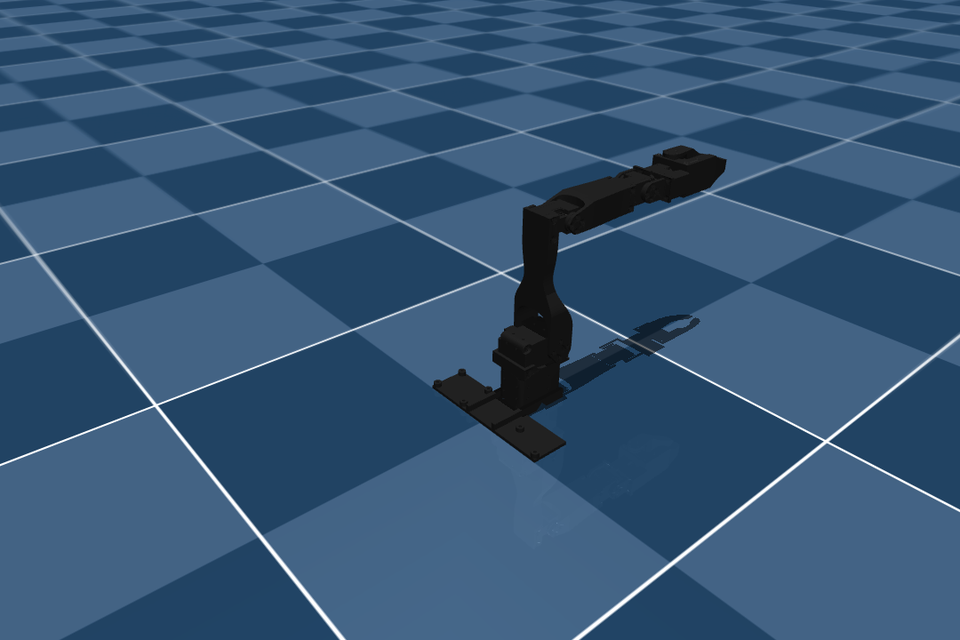
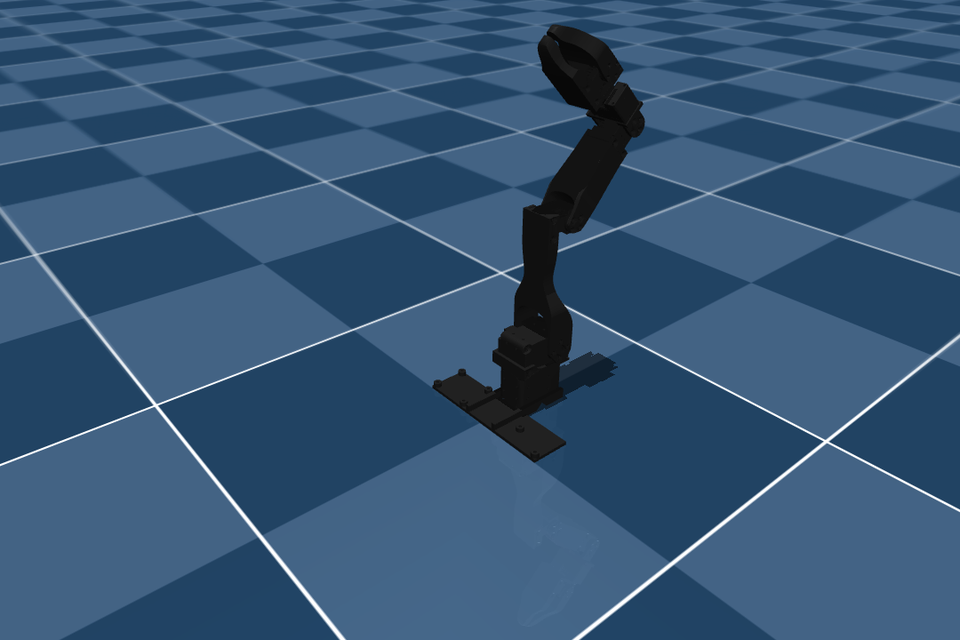

In [ ]:
qinit = data.qpos.copy()
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
init_plot = renderer.render()


# init_point = data.body(jname).xpos.copy()
normalized_qpos = [0.5, 0.5, 0.5, 1, 0, 0]
data.qpos = np.array([denormalize(idx, p) for idx, p in enumerate(normalized_qpos)])
qpos0 = data.qpos.copy()
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
after_plot = renderer.render()

images = {
    "initial point": init_plot,
    "after point": after_plot,
}
media.show_images(images=images, height=640)

In [62]:
def unit_vec(vec:np.ndarray):
    assert vec.ndim == 1 and vec.shape[0] == 3, f"Invalid vector input: {vec}"
    vec /= np.linalg.norm(vec)
    return vec

def angle_interpolate(np_datas, weights=None):
    if weights is None:
        ds = np.array([unit_vec(d) for d in np_datas])
    else:
        assert np.abs(np.sum(weights) - 1) < 1e-8
        ds = np.array([unit_vec(d) * w for d, w in zip(np_datas, weights)])
    interp_vec = np.sum(ds, axis=0)
    interp_vec /= np.linalg.norm(interp_vec)
    return interp_vec


def euclid3d_to_polar1d(euc):
    r = np.linalg.norm([euc[0], euc[1]])
    theta = np.arctan2(euc[1]/r, euc[0]/r)
    return theta

In [63]:
def debug_cross(**kwargs):
    elems = []
    if kwargs.get("debug", False):
        for k,v in kwargs.items():
            if k != "debug":
                print(f"{k}: {v}")
                elems.append(v)
    return np.cross(elems[0], elems[1])

In [64]:
a = angle_interpolate(np_datas=[np.array([1.0, 0.0, 0.]), np.array([0., 0., 1.])], weights=[1/3, 2/3])
print(a)
print(np.array([np.sin(np.pi/6), 0, np.cos(np.pi/6)]))
# seems quite different, but ignore small error

[0.4472136  0.         0.89442719]
[0.5       0.        0.8660254]


In [65]:
def torso_norm_vec(np_data):
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    l_sholder, r_sholder, l_hip, r_hip = np_data[Joint.L_SHOLDER.value], np_data[Joint.R_SHOLDER.value], np_data[Joint.L_HIP.value], np_data[Joint.R_HIP.value]
    l_elbow, l_wrist = np_data[Joint.L_ELBOW.value], np_data[Joint.L_WRIST.value]
    r_elbow, r_wrist = np_data[Joint.R_ELBOW.value], np_data[Joint.R_WRIST.value]

    l_sholder_to_r_hip, r_sholder_to_l_hip = unit_vec(r_hip - l_sholder), unit_vec(l_hip - r_sholder)
    l_sholder_to_elbow, l_elbow_to_wrist = unit_vec(l_elbow - l_sholder), unit_vec(l_wrist - l_elbow)
    r_sholder_to_elbow, r_elbow_to_wrist = unit_vec(r_elbow - r_sholder), unit_vec(r_wrist - r_elbow)
    torso_n = debug_cross(r_sholder_to_l_hip=r_sholder_to_l_hip, l_sholder_to_r_hip=l_sholder_to_r_hip, debug=True) 
    l_arm_n = debug_cross(l_elbow_to_wrist=l_elbow_to_wrist, l_sholder_to_elbow=l_sholder_to_elbow, debug=True)
    r_arm_n = debug_cross(r_elbow_to_wrist=r_elbow_to_wrist, r_sholder_to_elbow=r_sholder_to_elbow, debug=True)
    torso_n = angle_interpolate([torso_n, l_arm_n, r_arm_n], weights=[2/4, 1/4, 1/4])
    return torso_n
torso_n = torso_norm_vec(np_data=np_data[f])

r_sholder_to_l_hip: [ 0.50835161  0.33727012 -0.79235567]
l_sholder_to_r_hip: [ 0.01433969 -0.58315855 -0.81223179]
l_elbow_to_wrist: [-0.97582078  0.10444717 -0.19200157]
l_sholder_to_elbow: [ 0.3210372   0.31976865 -0.89145001]
r_elbow_to_wrist: [ 0.05981723 -0.44500272 -0.89352922]
r_sholder_to_elbow: [ 0.4140143  -0.64995955 -0.63729486]


In [66]:
def head_norm_vec(np_data):
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    # l_eye, r_eye = np_data[Joint.L_EYE.value], np_data[Joint.R_EYE.value]
    l_ear, r_ear = np_data[Joint.L_EAR.value], np_data[Joint.R_EAR.value]
    l_sholder, r_sholder = np_data[Joint.L_SHOLDER.value], np_data[Joint.R_SHOLDER.value]
    neck = (l_sholder + r_sholder) / 2
    l_ear_to_r_ear = unit_vec(l_ear - r_ear)
    mid_ear = (l_ear + r_ear) / 2
    mid_ear_to_neck = unit_vec(neck - mid_ear)
    # print(f"mid_ear_to_neck: {mid_ear_to_neck}")
    # print(f"l_ear_to_r_ear: {l_ear_to_r_ear}")
    head_n = debug_cross(mid_ear_to_neck=mid_ear_to_neck, l_ear_to_r_ear=l_ear_to_r_ear, debug=True) 
    return head_n
head_n = head_norm_vec(np_data[f])

mid_ear_to_neck: [ 0.54825767 -0.35733378 -0.75612571]
l_ear_to_r_ear: [0.80572401 0.58586465 0.08701397]


In [67]:
def leg_hinge_norm_vec(np_data):
    def calc_one_leg(hip, knee, ankle):
        up, down = unit_vec(hip - knee), unit_vec(knee - ankle)
        n = np.cross(up, down)
        up_norm_vec = np.cross(n, up)
        down_norm_vec = np.cross(n, down)
        return up_norm_vec, down_norm_vec
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    l_hip, l_knee, l_ankle = np_data[Joint.L_HIP.value], np_data[Joint.L_KNEE.value], np_data[Joint.L_ANKLE.value]
    r_hip, r_knee, r_ankle = np_data[Joint.R_HIP.value], np_data[Joint.R_KNEE.value], np_data[Joint.R_ANKLE.value]
    l_up_n, l_down_n = calc_one_leg(l_hip, l_knee, l_ankle)
    r_up_n, r_down_n = calc_one_leg(r_hip, r_knee, r_ankle)
    return l_up_n, l_down_n, r_up_n, r_down_n
def leg_norm_vec(np_data):
    lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n = leg_hinge_norm_vec(np_data)
    leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
    return leg_n
lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n = leg_hinge_norm_vec(np_data=np_data[f])

In [68]:
leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
barrel_norm_vec = angle_interpolate([leg_n, torso_n])

In [69]:
def angle_between_vectors(u: np.ndarray, v: np.ndarray):
    u = u / np.linalg.norm(u)
    v = v / np.linalg.norm(v)
    dot_val = np.dot(u, v)
    # 수치 에러 방지용 clip
    dot_val = np.clip(dot_val, -1.0, 1.0)
    angle = np.arccos(dot_val)
    return angle

In [ ]:
def signed_angle_between(u: np.ndarray, v: np.ndarray, n: np.ndarray):
    """
    u, v는 3D 벡터, n은 기준이 되는 노멀 벡터(예: 두 벡터가 속한 평면의 노멀).
    n은 단위벡터(normalized)여야 하며, u와 v도 일반적으로 단위벡터로 두는 것이 좋다.
    """
    # 단위벡터화
    u = u / np.linalg.norm(u)
    v = v / np.linalg.norm(v)
    n = n / np.linalg.norm(n)
    
    # 기본 각도 (0 ~ π)
    angle = np.arccos(np.clip(np.dot(u, v), -1.0, 1.0))
    # 외적을 통해 회전 방향 판단
    cross_uv = np.cross(u, v)
    # n과 cross_uv가 얼마나 정렬되어 있는지에 따라 부호 결정
    sign = np.sign(np.dot(n, cross_uv))
    
    # sign이 양수면 angle 유지, 음수면 angle에 음수 부호를 부여
    signed_angle = angle * sign
    return signed_angle


In [77]:
def signed_angle_between_vectors(u, v):
    angle = angle_between_vectors(u, v)
    if u[2] < v[2]:
        return -angle
    else:
        return angle

In [ ]:
def joint1():
    xy_theta = euclid3d_to_polar1d(-barrel_norm_vec)
    return xy_theta
    normalized = xy_theta / np.pi / 2 + np.pi / 2
    joint1_theta = denormalize(idx=0, point=normalized)
    return joint1_theta, barrel_norm_vec

joint1()


np.float64(0.08165499864254268)

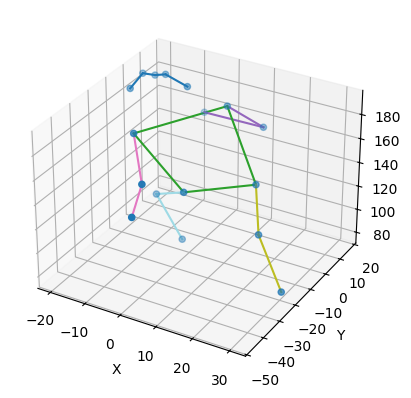

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colormaps
from vis_util import connections, connection_info, set_part_color

kpts_3d = np_data

# 특정 프레임 선택 (예: 첫 번째 프레임)
frame_kpts = kpts_3d[f]  # shape: (17, 3)

# x, y, z 좌표 분리
x = frame_kpts[:, 0]
y = frame_kpts[:, 1]
z = frame_kpts[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 점 플롯
ax.scatter(x, y, z)

cmap = colormaps["tab20"].resampled(len(connection_info))
for i, (start, end) in enumerate(connections):
    xs = [x[start], x[end]]
    ys = [y[start], y[end]]
    zs = [z[start], z[end]]
    ax.plot(xs, ys, zs, c=cmap.colors[set_part_color((start, end))[0]])

# 축 라벨
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [76]:
np_data[0][:5]

array([[-16.61279889,   3.10065302, 192.6734812 ],
       [-13.90004483,   0.88680626, 195.93660971],
       [-19.86587116,   1.42185223, 195.26577436],
       [ -9.22880018,  -6.86800707, 193.62756633],
       [-24.36041742,  -7.33786807, 192.16186395]])

In [35]:
head_n = head_norm_vec(np_data[f])
head_n

mid_ear_to_neck: [ 0.45442957 -0.31960214 -0.83147354]
l_ear_to_r_ear: [0.93036728 0.27879216 0.23810011]


array([ 0.155711  , -0.8817755 ,  0.42403877])

In [38]:
angle_interpolate([lleg_down_n, lleg_up_n])

array([-0.32799552, -0.87572348, -0.35429836])

In [36]:
torso_n = torso_norm_vec(np_data[f])
torso_n

r_sholder_to_l_hip: [ 0.5933496   0.21619184 -0.77536917]
l_sholder_to_r_hip: [-0.21613561 -0.29078542 -0.93205645]
l_elbow_to_wrist: [ 0.98074231  0.19122974 -0.0396951 ]
l_sholder_to_elbow: [ 0.93307773  0.34258665 -0.10954602]
r_elbow_to_wrist: [-0.49783156  0.86570251 -0.0521814 ]
r_sholder_to_elbow: [-0.34603198  0.21729532 -0.91271278]


array([-0.72133903,  0.61807521,  0.31249486])

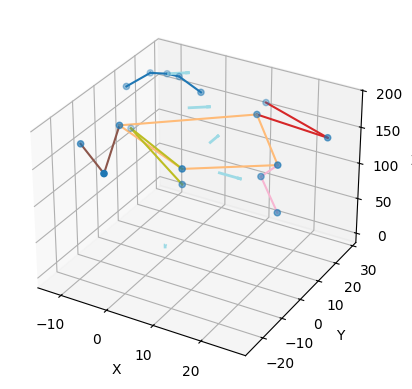

In [156]:
# -------------------------------------
# 기존 코드
# -------------------------------------
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colormaps
from vis_util import connections, connection_info, set_part_color, Joint

kpts_3d = np_data

frame_kpts = kpts_3d[f]  # shape: (17, 3)

# x, y, z 좌표 분리
x = frame_kpts[:, 0]
y = frame_kpts[:, 1]
z = frame_kpts[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 점 플롯
ax.scatter(x, y, z)

cmap = colormaps["tab20"].resampled(len(connection_info) + 1)
for i, (start, end) in enumerate(connections):
    xs = [x[start], x[end]]
    ys = [y[start], y[end]]
    zs = [z[start], z[end]]
    ax.plot(xs, ys, zs, c=cmap.colors[set_part_color((start, end))[0]])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# -------------------------------------
# 추가된 코드 (법선 벡터 시각화)
# -------------------------------------

# 예시로 barrel_n, leg_n, torso_n, head_n이 이미 계산되어 있다고 가정
# 예: barrel_n, leg_n, torso_n, head_n = ...
# 여기서는 dummy로 정의 (실제로는 사용자가 계산한 값을 넣어야 함)
barrel_n = np.array([0,0,1])    # 예: z축 방향
leg_n = np.array([1,0,0])       # 예: x축 방향
torso_n = np.array([0,1,0])     # 예: y축 방향
head_n = np.array([0.7,0.7,0])  # 예: 대략 대각선 방향

# 1. joint1(barrel_n): xy=(0,0)에서 z축과 이루는 각도를 표시
#   -> 시작점: 원점(0,0,0)

arrow_color = cmap.colors[-1]
origin = np.array([0,0,0])
ax.quiver(origin[0], origin[1], origin[2],
          barrel_n[0], barrel_n[1], barrel_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

# 2. joint2(leg_n): left_leg와 right_leg 좌표들의 평균 지점에서 법선 벡터 표시
leg_joints = [Joint.L_HIP.value, Joint.R_HIP.value, Joint.L_KNEE.value, Joint.R_KNEE.value, Joint.L_ANKLE.value, Joint.R_ANKLE.value]
leg_points = frame_kpts[leg_joints]
leg_center = np.mean(leg_points, axis=0)
ax.quiver(leg_center[0], leg_center[1], leg_center[2],
          leg_n[0], leg_n[1], leg_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

# 3. joint3(torso_n): L_SHOLDER, R_SHOLDER, L_HIP, R_HIP 중점에서 torso_n 표시
torso_joints = [Joint.L_SHOLDER.value, Joint.R_SHOLDER.value, Joint.L_HIP.value, Joint.R_HIP.value]
torso_points = frame_kpts[torso_joints]
torso_center = np.mean(torso_points, axis=0)
ax.quiver(torso_center[0], torso_center[1], torso_center[2],
          torso_n[0], torso_n[1], torso_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

# 4. joint4(head_n): torso의 중점과 nose point의 중점에서 head_n 표시
nose_point = frame_kpts[Joint.NOSE.value]
mid_torso_nose = (torso_center + nose_point) / 2
ax.quiver(mid_torso_nose[0], mid_torso_nose[1], mid_torso_nose[2],
          head_n[0], head_n[1], head_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

# 5. joint5(head_n): nose point에서 head_n 표시
ax.quiver(nose_point[0], nose_point[1], nose_point[2],
          head_n[0], head_n[1], head_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

plt.show()

In [ ]:
def joints(lleg_down_n, rleg_down_n, lleg_up_n, rleg_up_n, torso_n, head_n):
    def joint1():
        leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
        barrel_norm_vec = angle_interpolate([leg_n, torso_n, head_n])
        xy_theta = euclid3d_to_polar1d(-barrel_norm_vec)
        return xy_theta
        normalized = xy_theta / np.pi / 2 + np.pi / 2
        joint1_theta = denormalize(idx=0, point=normalized)
        return joint1_theta, barrel_norm_vec

    def joint2():
        leg_down_n = angle_interpolate([lleg_down_n, rleg_down_n])
        leg_down_n_proj_xy = np.array([*leg_down_n[:2], 0])
        theta = signed_angle_between_vectors(leg_down_n_proj_xy, leg_down_n)
        theta = np.clip(theta, ranges[1][1], ranges[1][0])
        return theta, leg_down_n
    joint2_theta, leg_down_n = joint2()

    def joint3():
        leg_up_n = angle_interpolate([lleg_up_n, rleg_up_n])
        signed_angle_between_vectors(leg_down_n, leg_up_n)


    # def joint3(lleg_up_n, rleg_up_n):
    #     leg_up_n = angle_interpolate([lleg_up_n, rleg_up_n])
    #     cos_theta = leg_up_n[2]
        

    

In [85]:

def calc_body_vectors(np_data):
    """ np_data: shape (17,3) 한 프레임의 3D 관절 좌표
    Joint enum:
        L_SHOLDER = 5, R_SHOLDER = 6,
        L_ELBOW = 7, R_ELBOW = 8,
        L_WRIST = 9, R_WRIST = 10,
        L_HIP = 11, R_HIP = 12,
        L_KNEE = 13, R_KNEE = 14,
        L_ANKLE = 15, R_ANKLE = 16,
        HEAD(가정) = NOSE=0 혹은 EYE/EAR 기반.
    """

    def debug_cross(**kwargs):
        # debug=False일 경우 무시
        vs = [v for k,v in kwargs.items() if k!="debug"]
        return np.cross(vs[0], vs[1])

    def torso_norm_vec(np_data):
        l_sh = np_data[Joint.L_SHOLDER.value]
        r_sh = np_data[Joint.R_SHOLDER.value]
        l_hip = np_data[Joint.L_HIP.value]
        r_hip = np_data[Joint.R_HIP.value]

        # 어깨-엉덩이 벡터
        l_sh_to_r_hip = unit_vec(r_hip - l_sh)
        r_sh_to_l_hip = unit_vec(l_hip - r_sh)

        # 팔면은 대략 torso 방향 산출에 사용 (선택적)
        l_elbow = np_data[Joint.L_ELBOW.value]
        l_wrist = np_data[Joint.L_WRIST.value]
        r_elbow = np_data[Joint.R_ELBOW.value]
        r_wrist = np_data[Joint.R_WRIST.value]

        l_sh_to_elbow = unit_vec(l_elbow - l_sh)
        l_elbow_to_wrist = unit_vec(l_wrist - l_elbow)
        r_sh_to_elbow = unit_vec(r_elbow - r_sh)
        r_elbow_to_wrist = unit_vec(r_wrist - r_elbow)

        torso_n = debug_cross(r_sh_to_l_hip=r_sh_to_l_hip, l_sh_to_r_hip=l_sh_to_r_hip)
        l_arm_n = debug_cross(l_elbow_to_wrist=l_elbow_to_wrist, l_sh_to_elbow=l_sh_to_elbow)
        r_arm_n = debug_cross(r_elbow_to_wrist=r_elbow_to_wrist, r_sh_to_elbow=r_sh_to_elbow)
        torso_n = angle_interpolate([torso_n, l_arm_n, r_arm_n], weights=[0.5, 0.25, 0.25])
        return unit_vec(torso_n)

    def leg_hinge_norm_vec(np_data):
        def calc_one_leg(hip, knee, ankle):
            up = unit_vec(hip - knee)
            down = unit_vec(knee - ankle)
            n = np.cross(up, down)
            up_norm_vec = np.cross(n, up)
            down_norm_vec = np.cross(n, down)
            return up_norm_vec, down_norm_vec
        l_hip = np_data[Joint.L_HIP.value]
        l_knee = np_data[Joint.L_KNEE.value]
        l_ankle = np_data[Joint.L_ANKLE.value]
        r_hip = np_data[Joint.R_HIP.value]
        r_knee = np_data[Joint.R_KNEE.value]
        r_ankle = np_data[Joint.R_ANKLE.value]

        l_up_n, l_down_n = calc_one_leg(l_hip, l_knee, l_ankle)
        r_up_n, r_down_n = calc_one_leg(r_hip, r_knee, r_ankle)
        return l_up_n, l_down_n, r_up_n, r_down_n

    torso_n = torso_norm_vec(np_data)
    l_up_n, l_down_n, r_up_n, r_down_n = leg_hinge_norm_vec(np_data)

    leg_n = angle_interpolate([l_up_n, l_down_n, r_up_n, r_down_n])

    # 머리는 대략 nose를 기준으로 torso와 반대편에 있다는 가정
    # head_n: torso의 방향에서 head 방향을 추출하는건 애매하므로, 여기서는 torso 상단에서 nose 방향 벡터를 이용
    # 그냥 torso_n과 nose의 상대 위치로 근사하거나, 혹은 eye/ear를 통해 추정 가능
    # 여기서는 간단히 torso 위치 중심(어깨, 엉덩이 평균)에서 nose로 가는 벡터를 정의
    center = (np_data[Joint.L_SHOLDER.value] + np_data[Joint.R_SHOLDER.value] + np_data[Joint.L_HIP.value] + np_data[Joint.R_HIP.value]) / 4
    head_dir = unit_vec(np_data[Joint.NOSE.value] - center)
    head_n = head_dir

    return leg_n, torso_n, head_n, l_up_n, l_down_n, r_up_n, r_down_n


def compute_joints(np_data):
    leg_n, torso_n, head_n, l_up_n, l_down_n, r_up_n, r_down_n = calc_body_vectors(np_data)

    # barrel_norm_vec: 다리, 상체, 머리 벡터를 종합한 방향
    barrel_norm_vec = angle_interpolate([leg_n, torso_n, head_n])

    # 왼쪽 방향 벡터 정의
    # 가정: z축이 위쪽이라 할 때(up_vec=[0,0,1]), left_vec = np.cross(up_vec, barrel_norm_vec)
    up_vec = np.array([0,0,1.0])
    left_vec = np.cross(up_vec, barrel_norm_vec)
    if np.linalg.norm(left_vec) < 1e-9:
        # 만약 배럴 벡터가 거의 상향이라면, 다른 기준 필요
        # 여기서는 그냥 y축을 left로 둔다고 가정
        left_vec = np.array([0,1,0])
    left_vec = unit_vec(left_vec)

    # joint1: barrel 회전 (xy plane 상에서 barrel_norm_vec의 방향)
    xy_theta = euclid3d_to_polar1d(-barrel_norm_vec)
    joint1 = xy_theta

    # joint2: leg_down_n을 이용
    leg_down_n = angle_interpolate([l_down_n, r_down_n])
    leg_down_n_proj_xy = np.array([leg_down_n[0], leg_down_n[1], 0])
    joint2 = signed_angle_between_vectors(leg_down_n_proj_xy, leg_down_n, left_vec)

    # joint3: 상체(torso_n)가 다리(leg_up_n)와 이루는 각도
    leg_up_n = angle_interpolate([l_up_n, r_up_n])
    joint3 = signed_angle_between_vectors(leg_up_n, torso_n, left_vec)

    # joint4: 상체와 머리가 이루는 각도
    joint4 = signed_angle_between_vectors(torso_n, head_n, left_vec)

    # joint5: 머리가 돌아간 각도
    # 여기서는 head_n을 barrel_norm_vec를 기준으로 yaw처럼 측정하는 예시
    # 머리 방향(head_n)을 xy 평면에 투영한 뒤 barrel_norm_vec에 대한 signed angle
    head_xy = unit_vec(np.array([head_n[0], head_n[1], 0]))
    barrel_xy = unit_vec(np.array([barrel_norm_vec[0], barrel_norm_vec[1], 0]))
    joint5 = signed_angle_between_vectors(barrel_xy, head_xy, left_vec)

    # joint6 고정
    joint6 = 0.0

    return joint1, joint2, joint3, joint4, joint5, joint6

In [87]:
def unit_vec(vec: np.ndarray):
    vec = vec.copy()
    vec /= np.linalg.norm(vec)
    return vec

def angle_interpolate(np_datas, weights=None):
    if weights is None:
        ds = np.array([unit_vec(d) for d in np_datas])
    else:
        assert np.abs(np.sum(weights) - 1) < 1e-8
        ds = np.array([unit_vec(d) * w for d, w in zip(np_datas, weights)])
    interp_vec = np.sum(ds, axis=0)
    interp_vec /= np.linalg.norm(interp_vec)
    return interp_vec

def euclid3d_to_polar1d(euc):
    # euc: [x, y, z]
    r = np.linalg.norm([euc[0], euc[1]])
    if r < 1e-9:
        return 0.0
    theta = np.arctan2(euc[1]/r, euc[0]/r)
    return theta

def angle_between_vectors(u: np.ndarray, v: np.ndarray):
    u = u / np.linalg.norm(u)
    v = v / np.linalg.norm(v)
    dot_val = np.dot(u, v)
    dot_val = np.clip(dot_val, -1.0, 1.0)
    angle = np.arccos(dot_val)
    return angle

def signed_angle_between_vectors(u: np.ndarray, v: np.ndarray, left_dir: np.ndarray):
    """
    u에서 v로 회전하는 각도를 구하되, 외적을 통해 방향성을 고려.
    left_dir는 몸의 "왼쪽" 방향을 나타내는 단위벡터로, 이를 기준으로 부호를 결정.
    """
    u = unit_vec(u)
    v = unit_vec(v)
    # 기본 각도 (0 ~ π)
    angle = angle_between_vectors(u, v)
    cross_uv = np.cross(u, v)
    # 왼쪽 방향 벡터와 cross_uv의 내적을 이용해 부호 결정
    # dot(left_dir, cross_uv) > 0 이면 u에서 v로 가는 회전이 왼쪽 방향을 형성하므로 +, 반대면 -.
    sign = np.sign(np.dot(left_dir, cross_uv))
    signed_angle = angle * sign
    return signed_angle

In [88]:
def calc_body_vectors(np_data):
    """ np_data: shape (17,3) 한 프레임의 3D 관절 좌표
    Joint enum:
        L_SHOLDER = 5, R_SHOLDER = 6,
        L_ELBOW = 7, R_ELBOW = 8,
        L_WRIST = 9, R_WRIST = 10,
        L_HIP = 11, R_HIP = 12,
        L_KNEE = 13, R_KNEE = 14,
        L_ANKLE = 15, R_ANKLE = 16,
        HEAD(가정) = NOSE=0 혹은 EYE/EAR 기반.
    """
    # 여기서는 NOSE를 HEAD의 대략적 대표점으로 사용
    # 필요시 head_n 계산 로직 변경 가능
    from enum import Enum
    class Joint(Enum):
        NOSE = 0
        L_EYE = 1
        R_EYE = 2
        L_EAR = 3
        R_EAR = 4
        L_SHOLDER = 5
        R_SHOLDER = 6
        L_ELBOW = 7
        R_ELBOW = 8
        L_WRIST = 9
        R_WRIST = 10
        L_HIP = 11
        R_HIP = 12
        L_KNEE = 13
        R_KNEE = 14
        L_ANKLE = 15
        R_ANKLE = 16

    def debug_cross(**kwargs):
        # debug=False일 경우 무시
        vs = [v for k,v in kwargs.items() if k!="debug"]
        return np.cross(vs[0], vs[1])

    def torso_norm_vec(np_data):
        l_sh = np_data[Joint.L_SHOLDER.value]
        r_sh = np_data[Joint.R_SHOLDER.value]
        l_hip = np_data[Joint.L_HIP.value]
        r_hip = np_data[Joint.R_HIP.value]

        # 어깨-엉덩이 벡터
        l_sh_to_r_hip = unit_vec(r_hip - l_sh)
        r_sh_to_l_hip = unit_vec(l_hip - r_sh)

        # 팔면은 대략 torso 방향 산출에 사용 (선택적)
        l_elbow = np_data[Joint.L_ELBOW.value]
        l_wrist = np_data[Joint.L_WRIST.value]
        r_elbow = np_data[Joint.R_ELBOW.value]
        r_wrist = np_data[Joint.R_WRIST.value]

        l_sh_to_elbow = unit_vec(l_elbow - l_sh)
        l_elbow_to_wrist = unit_vec(l_wrist - l_elbow)
        r_sh_to_elbow = unit_vec(r_elbow - r_sh)
        r_elbow_to_wrist = unit_vec(r_wrist - r_elbow)

        torso_n = debug_cross(r_sh_to_l_hip=r_sh_to_l_hip, l_sh_to_r_hip=l_sh_to_r_hip)
        l_arm_n = debug_cross(l_elbow_to_wrist=l_elbow_to_wrist, l_sh_to_elbow=l_sh_to_elbow)
        r_arm_n = debug_cross(r_elbow_to_wrist=r_elbow_to_wrist, r_sh_to_elbow=r_sh_to_elbow)
        torso_n = angle_interpolate([torso_n, l_arm_n, r_arm_n], weights=[0.5, 0.25, 0.25])
        return unit_vec(torso_n)

    def leg_hinge_norm_vec(np_data):
        def calc_one_leg(hip, knee, ankle):
            up = unit_vec(hip - knee)
            down = unit_vec(knee - ankle)
            n = np.cross(up, down)
            up_norm_vec = np.cross(n, up)
            down_norm_vec = np.cross(n, down)
            return up_norm_vec, down_norm_vec
        l_hip = np_data[Joint.L_HIP.value]
        l_knee = np_data[Joint.L_KNEE.value]
        l_ankle = np_data[Joint.L_ANKLE.value]
        r_hip = np_data[Joint.R_HIP.value]
        r_knee = np_data[Joint.R_KNEE.value]
        r_ankle = np_data[Joint.R_ANKLE.value]

        l_up_n, l_down_n = calc_one_leg(l_hip, l_knee, l_ankle)
        r_up_n, r_down_n = calc_one_leg(r_hip, r_knee, r_ankle)
        return l_up_n, l_down_n, r_up_n, r_down_n

    torso_n = torso_norm_vec(np_data)
    l_up_n, l_down_n, r_up_n, r_down_n = leg_hinge_norm_vec(np_data)

    leg_n = angle_interpolate([l_up_n, l_down_n, r_up_n, r_down_n])

    # 머리는 대략 nose를 기준으로 torso와 반대편에 있다는 가정
    # head_n: torso의 방향에서 head 방향을 추출하는건 애매하므로, 여기서는 torso 상단에서 nose 방향 벡터를 이용
    # 그냥 torso_n과 nose의 상대 위치로 근사하거나, 혹은 eye/ear를 통해 추정 가능
    # 여기서는 간단히 torso 위치 중심(어깨, 엉덩이 평균)에서 nose로 가는 벡터를 정의
    center = (np_data[Joint.L_SHOLDER.value] + np_data[Joint.R_SHOLDER.value] + np_data[Joint.L_HIP.value] + np_data[Joint.R_HIP.value]) / 4
    head_dir = unit_vec(np_data[Joint.NOSE.value] - center)
    head_n = head_dir

    return leg_n, torso_n, head_n, l_up_n, l_down_n, r_up_n, r_down_n

def compute_joints(np_data):
    leg_n, torso_n, head_n, l_up_n, l_down_n, r_up_n, r_down_n = calc_body_vectors(np_data)

    # barrel_norm_vec: 다리, 상체, 머리 벡터를 종합한 방향
    barrel_norm_vec = angle_interpolate([leg_n, torso_n, head_n])

    # 왼쪽 방향 벡터 정의
    # 가정: z축이 위쪽이라 할 때(up_vec=[0,0,1]), left_vec = np.cross(up_vec, barrel_norm_vec)
    up_vec = np.array([0,0,1.0])
    left_vec = np.cross(up_vec, barrel_norm_vec)
    if np.linalg.norm(left_vec) < 1e-9:
        # 만약 배럴 벡터가 거의 상향이라면, 다른 기준 필요
        # 여기서는 그냥 y축을 left로 둔다고 가정
        left_vec = np.array([0,1,0])
    left_vec = unit_vec(left_vec)

    # joint1: barrel 회전 (xy plane 상에서 barrel_norm_vec의 방향)
    xy_theta = euclid3d_to_polar1d(-barrel_norm_vec)
    joint1 = xy_theta

    # joint2: leg_down_n을 이용
    leg_down_n = angle_interpolate([l_down_n, r_down_n])
    leg_down_n_proj_xy = np.array([leg_down_n[0], leg_down_n[1], 0])
    joint2 = signed_angle_between_vectors(leg_down_n_proj_xy, leg_down_n, left_vec)

    # joint3: 상체(torso_n)가 다리(leg_up_n)와 이루는 각도
    leg_up_n = angle_interpolate([l_up_n, r_up_n])
    joint3 = signed_angle_between_vectors(leg_up_n, torso_n, left_vec)

    # joint4: 상체와 머리가 이루는 각도
    joint4 = signed_angle_between_vectors(torso_n, head_n, left_vec)

    # joint5: 머리가 돌아간 각도
    # 여기서는 head_n을 barrel_norm_vec를 기준으로 yaw처럼 측정하는 예시
    # 머리 방향(head_n)을 xy 평면에 투영한 뒤 barrel_norm_vec에 대한 signed angle
    head_xy = unit_vec(np.array([head_n[0], head_n[1], 0]))
    barrel_xy = unit_vec(np.array([barrel_norm_vec[0], barrel_norm_vec[1], 0]))
    joint5 = signed_angle_between_vectors(barrel_xy, head_xy, left_vec)

    # joint6 고정
    joint6 = 0.0

    return joint1, joint2, joint3, joint4, joint5, joint6

Computed joint angles: (np.float64(-0.10952022281991053), np.float64(0.268047207655635), np.float64(0.680723063530727), np.float64(-1.4273687278622569), np.float64(0.0), 0.0)
Final qpos: [-1.57079633 -0.39269908  1.57079633 -1.57079633 -1.57079633  0.        ]


after joint angles

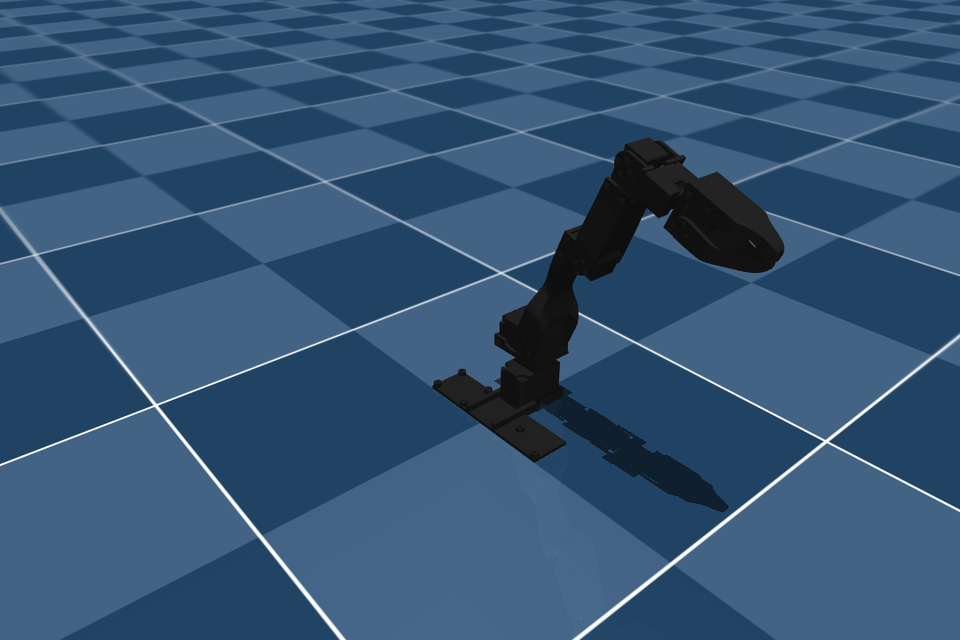

In [91]:
import numpy as np
import mujoco
import mediapy as media

# 이전에 정의한 ranges와 denormalize 함수, 그리고 Mujoco model, data, renderer, camera 존재한다고 가정
# 또한 compute_joints 함수와 np_data (모션캡쳐 keypoints)도 존재한다고 가정

f = 450 # 특정 프레임
joint_angles = compute_joints(np_data[f])  # (joint1, joint2, joint3, joint4, joint5, joint6)
print("Computed joint angles:", joint_angles)

# joint_angles는 현재 실제 각도(radian)값. 이를 [0,1]로 normalize 후 denormalize() 사용
# denormalize는 point를 [0,1]범위로 받음
# ranges: 각 joint별 [start, end]
# normalize: point = (angle - end) / (start - end)

normalized_qpos = [denormalize(i, ang) for i, ang in enumerate(joint_angles)]
final_qpos = np.array([denormalize(idx, p) for idx, p in enumerate(normalized_qpos)])
print("Final qpos:", final_qpos)

# Mujoco에 반영
data.qpos = final_qpos
mujoco.mj_forward(model, data)

# 렌더링
renderer.update_scene(data, camera)
current_plot = renderer.render()

images = {
    "after joint angles": current_plot
}
media.show_images(images=images, height=640)